#  Python Good/Bad Spectra Detection using Machine Learnig for R6G SERS Experiments
## Model Selection 

This notebook outlines the model selection for the experiments

## Setup 

Loading key packages

In [1]:
import sys 
sys.path.insert(0, "/ramanbox/")
import os
import git
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ramanbox.raman.sample_builder import SampleBuilder
from ramanbox.raman.sample import Sample
from ramanbox.raman.constants import Label
from fit_visualization import FittingVisualizer
from helper_funs import make_df, make_Xy
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
import copy

In [2]:
# import models used in classification 
from sklearn.linear_model import SGDClassifier  #1,2 
from sklearn.tree import DecisionTreeClassifier # 3 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 4 
from sklearn.ensemble import RandomForestClassifier # 5
from xgboost import XGBClassifier # 6

In [3]:
# import tools for classification
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV

In [4]:
random.seed(42)

## Data Loading

Loading data into memory 

In [5]:
labeled_data_dir = 'data'
figure_directory = '../'

In [6]:
#load labeled data 
net_cdf_files = glob.glob(os.path.join(labeled_data_dir, '*.nc'))
sample_list = []
for file in net_cdf_files:
    sample_list.append(Sample.build_from_netcdf(file))

In [7]:
# store wavenumbers in variable 
wavenumbers = sample_list[0].spot_list[0].spectrum_list[0].wavenumbers

In [8]:
# print index and name of loaded samples 
print('Loaded Samples')
for index, sample in enumerate(sample_list):
    print(index, sample.name)

Loaded Samples
0 20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_scan_1sec_exposure
1 20200226_moxtek_R6G_3mM_60X_10mW_20x20_scan_1sec_exposure
2 20200226_plasmore_R6G_10^-5mM_60X_10mW_20x20_scan_1sec_exposure
3 20200226_plasmore_R6G_10^-5mM_60X_20mW_20x20_scan_1sec_exposure
4 20200226_plasmore_R6G_3mM_60X_10mW_20x20_scan_1sec_exposure


## Train Test Split

For the model selection portion, the samples for each experiment are mixed together. This in-sample prediction ability is the 

Now use the helper functions make_df and get_X_Y to generate training data, validation data and test data without the "maybe" labeled spectra. 

In [9]:
X, y = make_Xy(make_df(sample_list))

### Determine Class Fraction

In [10]:
print('Positive Fraction ', sum(y), '/' , len(y), "{:.2f}".format(sum(y)/len(y)*100), '%')
print('Negative Fraction ', len(y) - sum(y), '/' , len(y), "{:.2f}".format((len(y) -sum(y))/len(y)*100), '%' )

Positive Fraction  940 / 1876 50.11 %
Negative Fraction  936 / 1876 49.89 %


In [11]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train_m_val, X_val, y_train_m_val, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [12]:
print("Train Data Set")
print('Positive Fraction ', sum(y_train), '/' , len(y_train), "{:.2f}".format(sum(y_train)/len(y_train)*100), '%')
print('Negative Fraction ', len(y_train) - sum(y_train), '/' , len(y_train), "{:.2f}".format((len(y_train) -sum(y_train))/len(y_train)*100), '%' )
print("Val Data Set")
print('Positive Fraction ', sum(y_val), '/' , len(y_val), "{:.2f}".format(sum(y_val)/len(y_val)*100), '%')
print('Negative Fraction ', len(y_val) - sum(y_val), '/' , len(y_val), "{:.2f}".format((len(y_val) -sum(y_val))/len(y_val)*100), '%' )
print("Test Data Set")
print('Positive Fraction ', sum(y_test), '/' , len(y_test), "{:.2f}".format(sum(y_val)/len(y_test)*100), '%')
print('Negative Fraction ', len(y_test) - sum(y_test), '/' , len(y_test), "{:.2f}".format((len(y_test) -sum(y_test))/len(y_test)*100), '%' )

Train Data Set
Positive Fraction  800 / 1594 50.19 %
Negative Fraction  794 / 1594 49.81 %
Val Data Set
Positive Fraction  116 / 240 48.33 %
Negative Fraction  124 / 240 51.67 %
Test Data Set
Positive Fraction  140 / 282 41.13 %
Negative Fraction  142 / 282 50.35 %


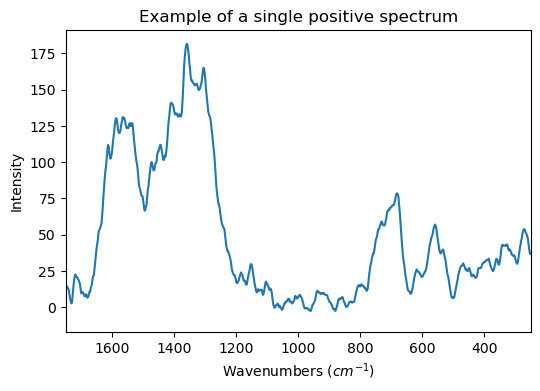

In [13]:
# Visualize first spectrum in train set
pos_index = 0
for i in range(0, len(y_train)):
    if y_train[i] == 1:
        pos_index = i
        
plt.figure(dpi=100)
plt.title("Example of a single positive spectrum")
plt.plot(wavenumbers, X_train[pos_index])
plt.xlim([1750, 250])
plt.xlabel("Wavenumbers $(cm^{-1})$")
plt.ylabel("Intensity")
plt.savefig(os.path.join(figure_directory, 'example_pos_spectrum.svg'))

****

In [14]:
# optimal hyperparamters
lr_sgd_gridsearch_best_params_ = {'alpha': 0.001,
                                 'l1_ratio': 0.1,
                                 'learning_rate': 'optimal',
                                 'loss': 'log',
                                 'max_iter': 5000,
                                 'n_jobs': -1,
                                 'penalty': 'elasticnet',
                                 'random_state': 42}

svg_sgd_gridsearch_best_params_ = {'alpha': 1e-05,
                                 'l1_ratio': 0.15000000000000002,
                                 'learning_rate': 'optimal',
                                 'loss': 'hinge',
                                 'max_iter': 5000,
                                 'n_jobs': -1,
                                 'penalty': 'elasticnet',
                                 'random_state': 42}

dt_gridsearch_best_params_ = {'max_depth': 4, 'max_features': 300}

rf_gridsearch_best_params_ = {'max_depth': 10, 'max_features': 'auto'}

optimal_xgboost_params = {'learning_rate': 0.0167,
                         'max_depth': 4,
                         'max_features': 5,
                         'min_sample_leaf': 1,
                         'min_sample_split': 1,
                         'n_estimators': 780,
                         'random_state': 42,
                         'subsample': 0.75}

****

In [15]:
import fit_visualization

In [16]:
from importlib import reload
reload(fit_visualization)

<module 'fit_visualization' from '/Users/dda/Box/2021 - Machine learning (TR)/Figures/notebooks/fit_visualization.py'>

## Fit Models and Compare Performance

Model List
1. Stochastic Gradient Descent Classifier with a logistic regression loss function (LR-SGD) 
2. Stochastic Gradient Descent Classifier with a linear SVG loss function (SVG-SGD)
3. Decision Tree Classifier (DT)
4. Linear Discriminant Analysis (LDA)
5. Random Forest (RF)
6. XGBoost (XGB) 

#### Create Classifiers with Optimal Parameters

In [17]:
lr_sgd = SGDClassifier(**lr_sgd_gridsearch_best_params_)
svg_sgd = SGDClassifier(**svg_sgd_gridsearch_best_params_)
dt = DecisionTreeClassifier(**dt_gridsearch_best_params_)
lda = LinearDiscriminantAnalysis()
rf = RandomForestClassifier(**rf_gridsearch_best_params_)
xgb = XGBClassifier(**optimal_xgboost_params)

In [18]:
# Create classifiers
classifier_list = [(lr_sgd, 'LR-SGD'),
                  (svg_sgd, 'SVG-SGD'),
                  (dt, 'DT'),
                  (lda, 'LDA'),
                  (rf, 'RF'),
                  (xgb, 'XGB')]

for clf, name in classifier_list:
    clf.fit(X_train_m_val, y_train_m_val)

## Use Validation Set to Assess Performance

In [19]:
prob_pos_dict = {}
scores_dict = {}

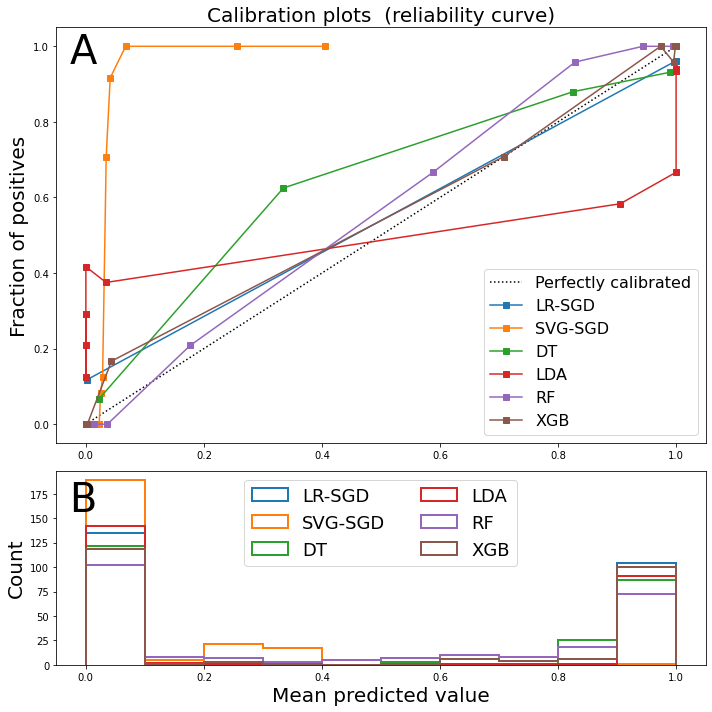

In [20]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for clf, name in classifier_list:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_val)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_val)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_val, prob_pos, n_bins=10, strategy='quantile')

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    
    prob_pos_dict[name] = prob_pos
    
ax1.set_ylabel("Fraction of positives", fontsize=20)
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right", fontsize=16)
ax1.set_title('Calibration plots  (reliability curve)', fontsize=20)
ax1.annotate("A", (0.02, 0.95), xycoords='axes fraction', va='center_baseline', fontsize=40, color = 'black')

ax2.set_xlabel("Mean predicted value", fontsize=20)
ax2.set_ylabel("Count", fontsize=20)
ax2.legend(loc="upper center", ncol=2, fontsize=18)
ax2.annotate("B", (0.02, 0.87), xycoords='axes fraction', va='center_baseline', fontsize=40, color = 'black')

plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'calibration_plots.svg'))
plt.show()


## ROC Curve

In [21]:
# saving a legend is more challenging than it should be 
# see the following for a solution
# https://stackoverflow.com/questions/10101700/moving-matplotlib-legend-outside-of-the-axis-makes-it-cutoff-by-the-figure-box

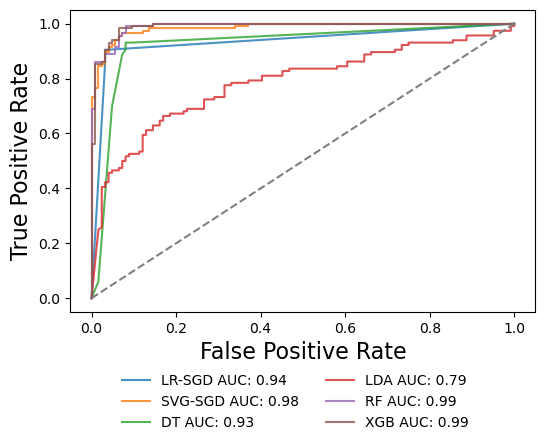

In [22]:
from sklearn import metrics
roc_dict = {}
fig = plt.figure(dpi=100)
for name, pos_rate in prob_pos_dict.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_val, pos_rate)
    auc = metrics.roc_auc_score(y_val, pos_rate)
    roc_dict[name] = (fpr, tpr, thresholds)
    plt.plot(fpr, tpr, linewidth=1.5, label=name + " AUC: " + "{0:0.2f}".format(auc), alpha=0.8)
lgd = fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=False, frameon=False, ncol=2)
plt.xlabel('False Positive Rate', fontsize=16) # Not shown
plt.ylabel('True Positive Rate', fontsize=16)    # Not shown
plt.plot([0,1],[0,1],'--',color='gray')
#plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig(os.path.join(figure_directory, 'roc_curve.svg'), bbox_extra_artists=(lgd,), bbox_inches='tight')


In [23]:
df = pd.DataFrame()
index_list = []
for model, name in classifier_list:
    index_list.append(name)
    y_pred = model.predict(X_val)
    fitvis = fit_visualization.FittingVisualizer(X_val, y_val, y_pred, y_scores=prob_pos_dict[name])
    df = df.append(fitvis.get_stats_df())
    

In [24]:
df.index = index_list
df

,Accuracy,Precision,Recall,F1,AUC_ROC
LR-SGD,0.916667,0.961538,0.862069,0.909091,0.935380
SVG-SGD,0.937500,0.939130,0.931034,0.935065,0.984705
DT,0.912500,0.913043,0.905172,0.909091,0.926237
LDA,0.741667,0.787234,0.637931,0.704762,0.785213
RF,0.929167,0.930435,0.922414,0.926407,0.989572
XGB,0.937500,0.931624,0.939655,0.935622,0.989711


In [25]:
df.to_excel(os.path.join(figure_directory, 'model_stats.xlsx'))

## The best performing model is XGBoost

We now more closely examine the Random Forest Performance

   Accuracy  Precision    Recall        F1   AUC_ROC
0    0.9375   0.931624  0.939655  0.935622  0.989711


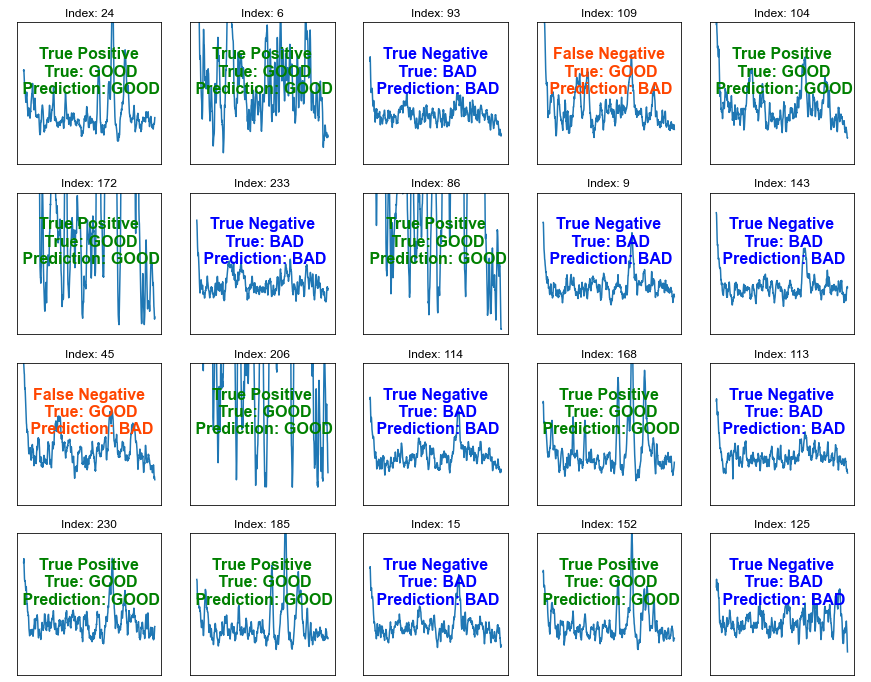

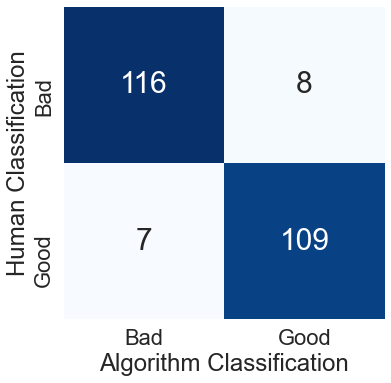

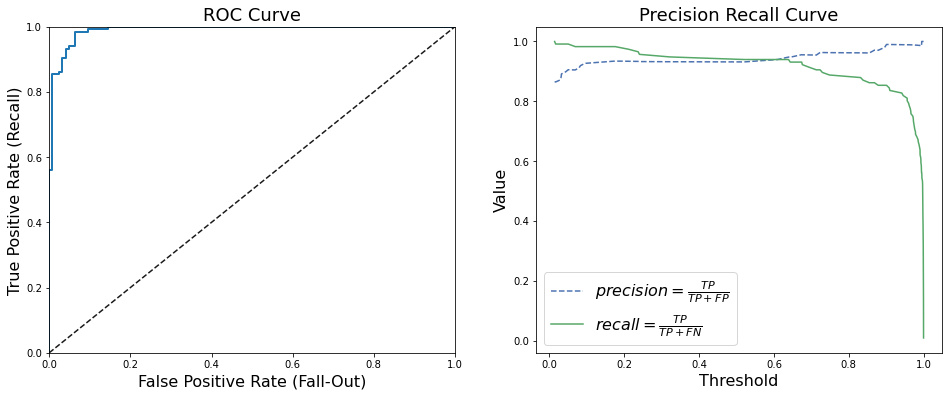

In [26]:
y_val_pred = xgb.predict(X_val)
y_val_scores = xgb.predict_proba(X_val)[:,1]
fitvis = fit_visualization.FittingVisualizer(X_val,y_val, y_val_pred, y_scores=y_val_scores, save_data=True)
fitvis.show_all()

****
****

## Final Test Score

Now that the Random Forrest Classifier has been identified as the top performing model, we use the test set to predict its performance

In [27]:
xgb.fit(X_train, y_train)

XGBClassifier(learning_rate=0.0167, max_depth=4, max_features=5,
              min_sample_leaf=1, min_sample_split=1, n_estimators=780,
              random_state=42, subsample=0.75)

   Accuracy  Precision  Recall   F1  AUC_ROC
0       1.0        1.0     1.0  1.0      1.0


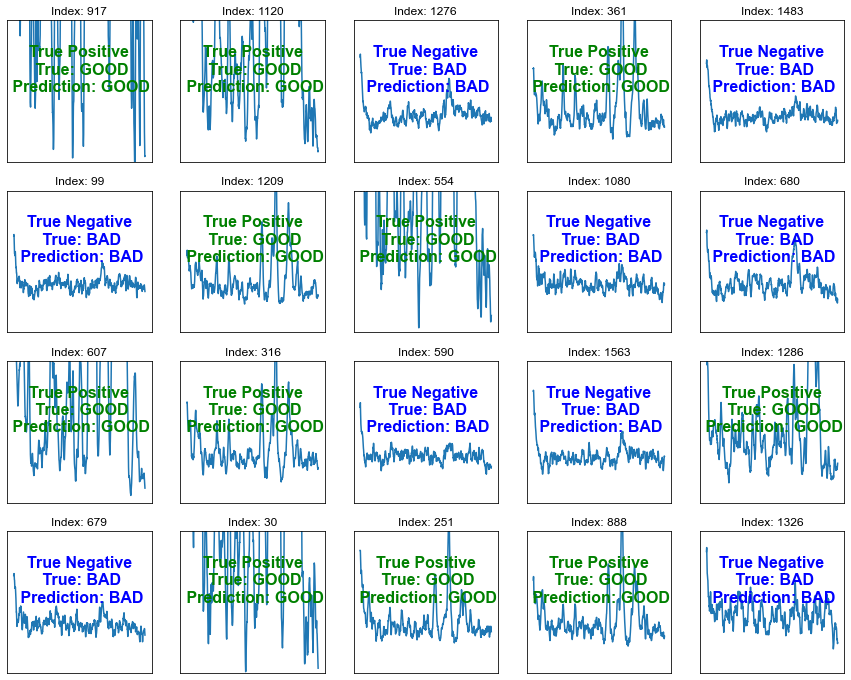

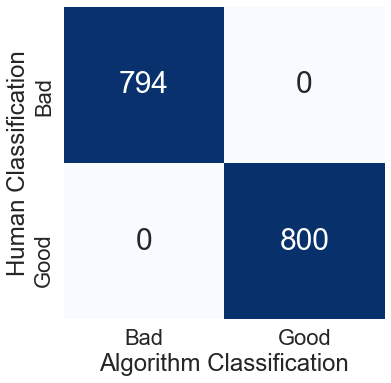

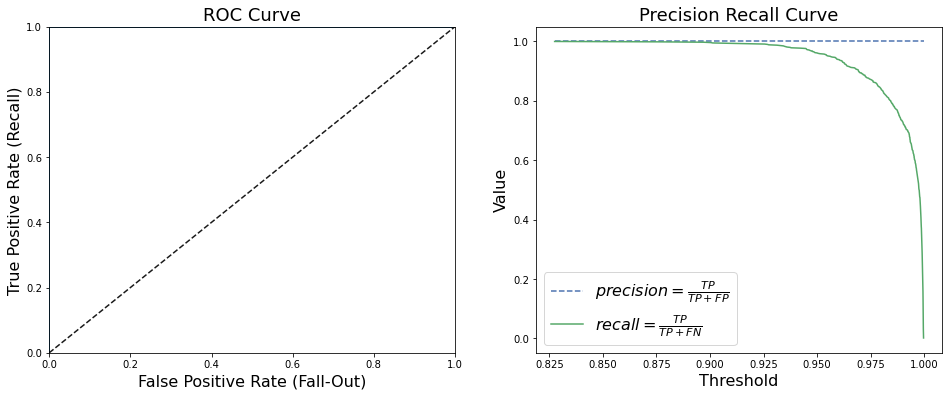

In [28]:
y_train_pred = xgb.predict(X_train)
y_train_scores = xgb.predict_proba(X_train)[:,1]
fitvis = fit_visualization.FittingVisualizer(X_train,y_train, y_train_pred, y_scores=y_train_scores)
fitvis.show_all()

   Accuracy  Precision    Recall        F1   AUC_ROC
0  0.946809    0.92517  0.971429  0.947735  0.989537


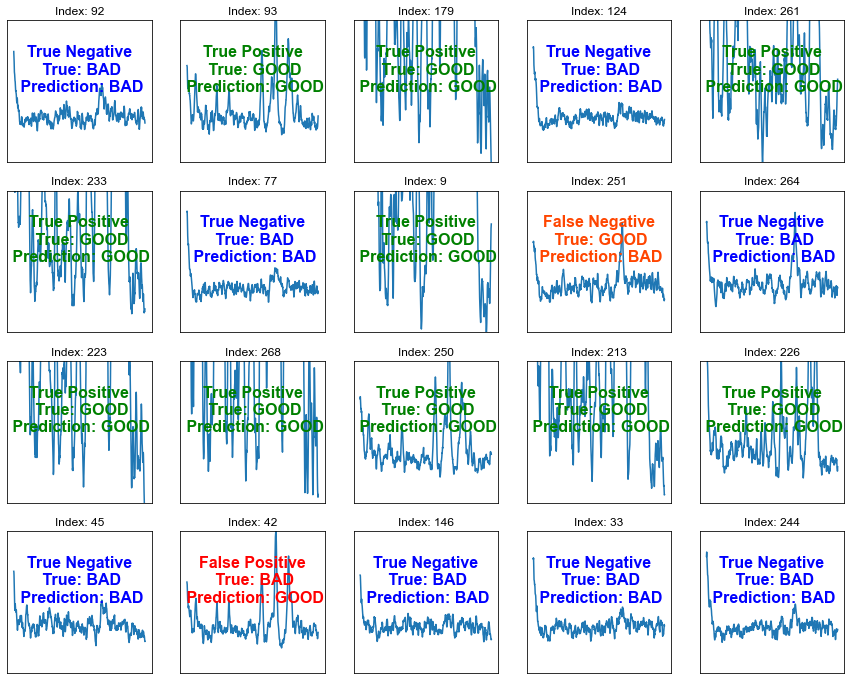

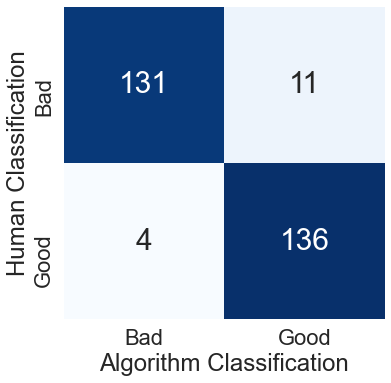

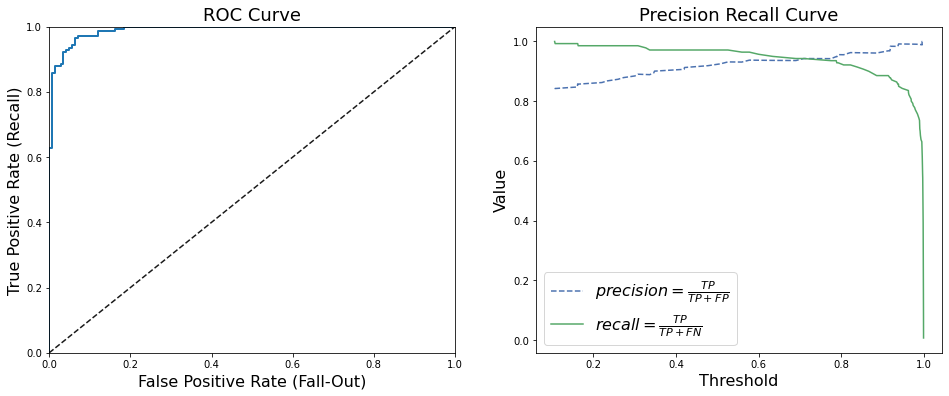

In [29]:
y_test_pred = xgb.predict(X_test)
y_test_scores = xgb.predict_proba(X_test)[:,1]
fitvis = fit_visualization.FittingVisualizer(X_test,y_test, y_test_pred, y_scores=y_test_scores)
fitvis.show_all()

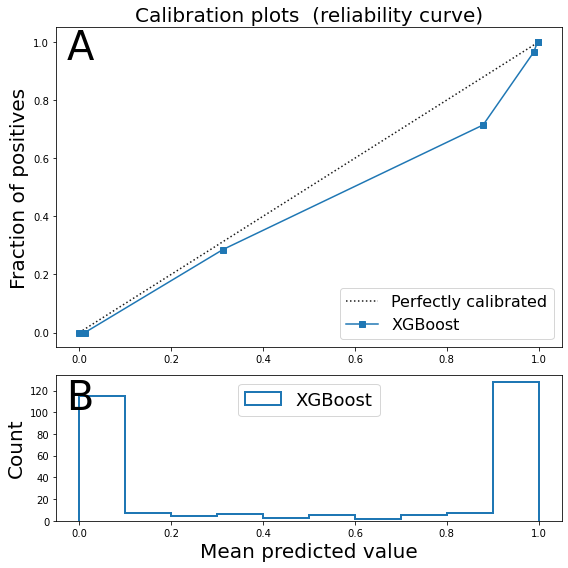

In [30]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for clf, name in [(xgb,'XGBoost')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10, strategy='quantile')

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    
    prob_pos_dict[name] = prob_pos
    
ax1.set_ylabel("Fraction of positives", fontsize=20)
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right", fontsize=16)
ax1.set_title('Calibration plots  (reliability curve)', fontsize=20)
ax1.annotate("A", (0.02, 0.95), xycoords='axes fraction', va='center_baseline', fontsize=40, color = 'black')

ax2.set_xlabel("Mean predicted value", fontsize=20)
ax2.set_ylabel("Count", fontsize=20)
ax2.legend(loc="upper center", ncol=2, fontsize=18)
ax2.annotate("B", (0.02, 0.87), xycoords='axes fraction', va='center_baseline', fontsize=40, color = 'black')

plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'calibration_plots.svg'))
plt.show()
fig.savefig(os.path.join(figure_directory, 'calibration_plot_XGBOOST_Test.svg'), bbox_inches='tight')

### Feature Importance Analysis 
In this code we assess how important each point in the specturm is. 

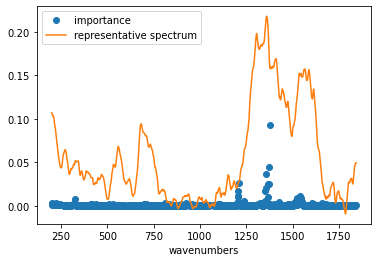

In [31]:
i = 0 
featureImportance = np.zeros((len(xgb.feature_importances_),2))
for e in xgb.feature_importances_:
    featureImportance[i,0] = wavenumbers[i]
    featureImportance[i,1] = e
    i+=1
fImportance = pd.DataFrame(featureImportance)
fImportance.columns = (("wavenumbers","importance"))
fNonZero = fImportance[fImportance["importance"]!=0]
fNonZero.sort_values(by="importance")
fNonZero.plot(x="wavenumbers",y="importance",marker='o',linestyle='')

spectrum = X_train[pos_index, :]

plt.plot(wavenumbers,1.2*spectrum/1000,label="representative spectrum")
plt.legend()
#fNonzero = fImportance[fImportance!=0]
#featureImportance[featureImportance[:,1].argsort()]
#print(featureImportance[0,1])


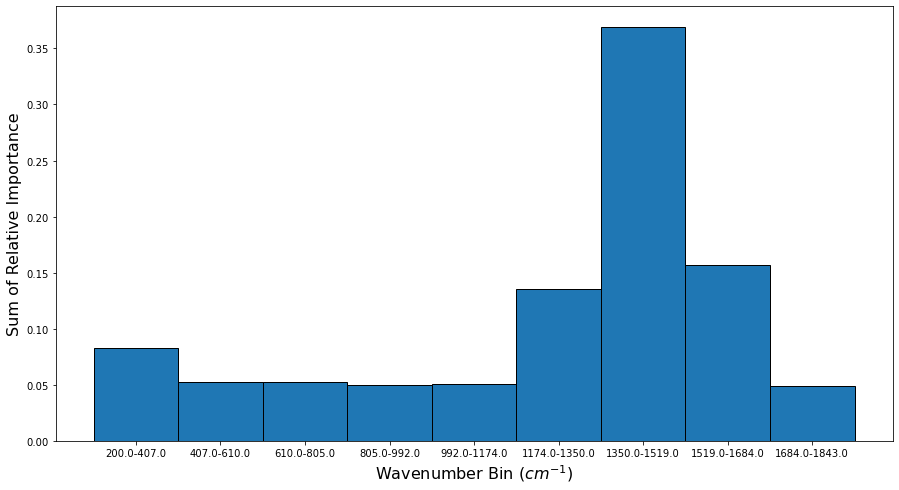

In [32]:
#make bins

num_of_bins = 10

bin_index = np.linspace(0,len(fImportance["wavenumbers"])-1,num_of_bins).astype(int)
bins = fImportance["wavenumbers"].sort_values().take(bin_index) #[fImportance["wavenumber"].iloc in bin_index]

#print(bin_index)

vals = fImportance["importance"].values
wns = fImportance["wavenumbers"].values
binDict = {}
binDict2 = {}
j = 0 
for i in bin_index:
    if(i==0): continue 
    sum = 0 
    for k in range(j,i):
        sum += vals[k]
    binDict[str(round(wns[j],0))+'-'+str(round(wns[i],0))] = sum
    meanWN = int((wns[j]+wns[i])/2)
    binDict2[meanWN] = sum
    j=i
keys = binDict.keys()
values = binDict.values()
sorted_tuple = sorted(zip(keys, values), key = lambda x: float(x[0].split('-')[0]), reverse=False)
keys = [val[0] for val in sorted_tuple]
values = [val[1] for val in sorted_tuple]
plt.bar(keys, values, width=1, edgecolor="black")
plt.gcf().set_size_inches(15, 8)
plt.xlabel("Wavenumber Bin $(cm^{-1})$", fontsize=16)
plt.ylabel("Sum of Relative Importance", fontsize=16)
plt.savefig(os.path.join(figure_directory, 'rf_rel_importance.svg'))